<a href="https://colab.research.google.com/github/meghakalia/Controllable_Image_Generation/blob/main/T2IAdapter_EdgeMask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🌗 Image-to-Image Translation with Stable Diffusion and T2I-Adapter (Canny-Edge)
This notebook demonstrates how to transform a daytime scene into a nighttime version using T2I-Adapter with Stable Diffusion XL. We use the edge-based adapter to preserve the structural layout of the original image while guiding the model to generate a photorealistic night scene.

## 🔧 Key Features:
*   Runs on **T4 GPU**
*   Loads a **pretrained T2I-Adapter** (Canny-Edge) model from TencentARC
*   **Uses Stable Diffusion XL** for high-quality image generation
* Extracts a edge map from an input day scene image
* **Conditions the diffusion model** with both the edge map and a text prompt (e.g., "a street at night")
* Outputs a high-resolution night version of the original image





# NOTE

1.   xformers should be isntalled before other libraries
2.   Restart the runtime after installing

In [ ]:
!pip install xformers --pre -U #

In [1]:

# ✅ STEP 1: Install dependencies
!pip install -q diffusers transformers accelerate controlnet-aux opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 32.0 MB/s eta 0:00:00


In [2]:
# ✅ STEP 2: Import packages
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from diffusers import StableDiffusionAdapterPipeline, T2IAdapter
# from controlnet_aux import MidasDetector
from transformers import AutoProcessor

from diffusers import StableDiffusionXLAdapterPipeline, T2IAdapter, EulerAncestralDiscreteScheduler, AutoencoderKL
# from diffusers.utils import load_image, make_image_grid
from controlnet_aux.canny import CannyDetector
# import torch

from torchvision import transforms
import requests
from io import BytesIO
from IPython.display import display
from IPython.display import display


from google.colab import files
from PIL import Image

# from diffusers import StableDiffusionXLAdapterPipeline, T2IAdapter, EulerAncestralDiscreteScheduler, AutoencoderKL


/usr/local/lib/python3.11/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [3]:
# Let the user upload an image
# # ✅ STEP 3: Load an image (You can upload your own in the next step)
uploaded = files.upload()

# Load and resize the image
filename = next(iter(uploaded))
day_img = Image.open(filename).convert("RGB").resize((512, 512))


Saving 2.jpg to 2.jpg


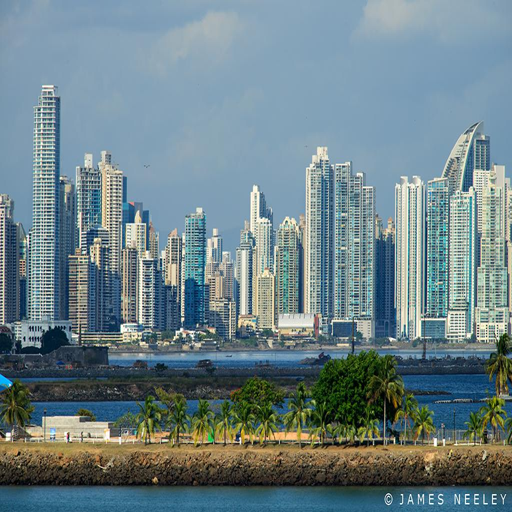

In [4]:
display(day_img)

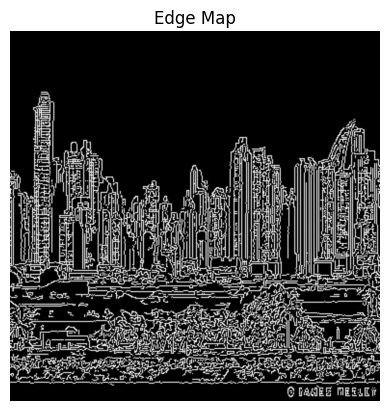

In [5]:
# ✅ STEP 4: Generate depth map from day image

canny_detector = CannyDetector()
image = canny_detector(day_img, detect_resolution=384, image_resolution=1024)#.resize((1024, 1024))

# Optional: show depth map
plt.imshow(image)
plt.title("Edge Map")
plt.axis("off")
plt.show()



In [7]:
# ✅ STEP 5: Load T2I-Adapter (depth) + Stable Diffusion XL
# load adapter

adapter = T2IAdapter.from_pretrained("TencentARC/t2i-adapter-canny-sdxl-1.0", torch_dtype=torch.float16, varient="fp16").to("cuda")

# load euler_a scheduler
model_id  = 'stabilityai/stable-diffusion-xl-base-1.0'
euler_a   = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
vae       = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe      = StableDiffusionXLAdapterPipeline.from_pretrained(
              model_id, vae=vae, adapter=adapter, scheduler=euler_a, torch_dtype=torch.float16, variant="fp16",
                ).to("cuda")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/316M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
try:
    pipe.enable_xformers_memory_efficient_attention()
    print("xformers enabled successfully!")
except Exception as e:
    print(f"Could not enable xformers: {e}")

xformers enabled successfully!


In [ ]:
# Manually delete models/pipes if out of memory
# del pipe
# del adapter
# del depth_map
# del day_img
# del output

# Run garbage collector
# import gc
# gc.collect()

# # Then clear CUDA cache again
# torch.cuda.empty_cache()
# torch.cuda.ipc_collect()

In [29]:
# # ✅ STEP 6: Define prompt to transform day → night
prompt = "indian temples, 4k picture, high quality"
negative_prompt = "painting, copyright text, animated, manga, cartoonish, cropped, worst quality, low quality, glitch, deformed, mutated, ugly, over exposed"

# building
#prompt = "indian temples, 4k picture, high quality"
#negative_prompt = "painting, copyright text, animated, manga, cartoonish, cropped, worst quality, low quality, glitch, deformed, mutated, ugly, over exposed"

  0%|          | 0/30 [00:00<?, ?it/s]

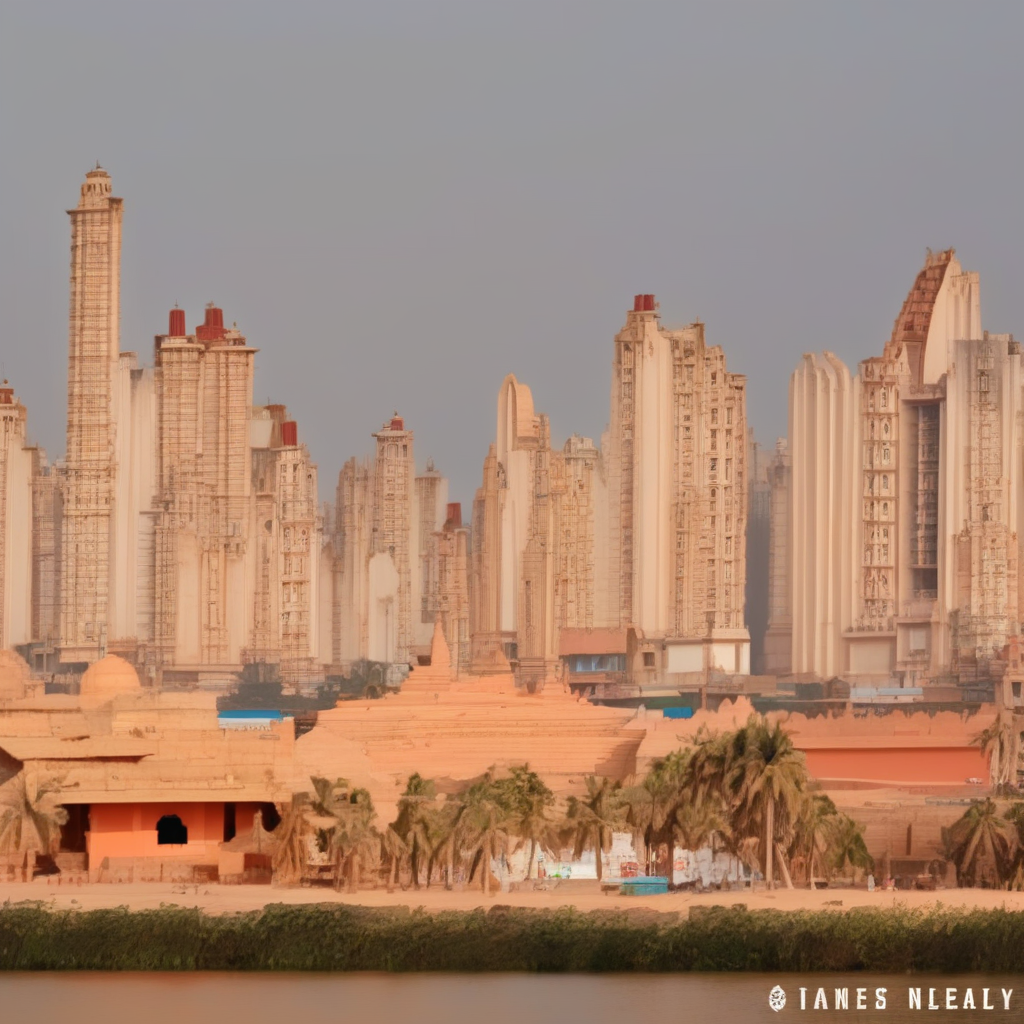

In [30]:
# ✅ STEP 7: Run generation

output = pipe(
  prompt=prompt,
  negative_prompt=negative_prompt,
  image=image,
  num_inference_steps=30,
  adapter_conditioning_scale=1,
  guidance_scale=7.5
).images[0]

display(output)

  0%|          | 0/30 [00:00<?, ?it/s]

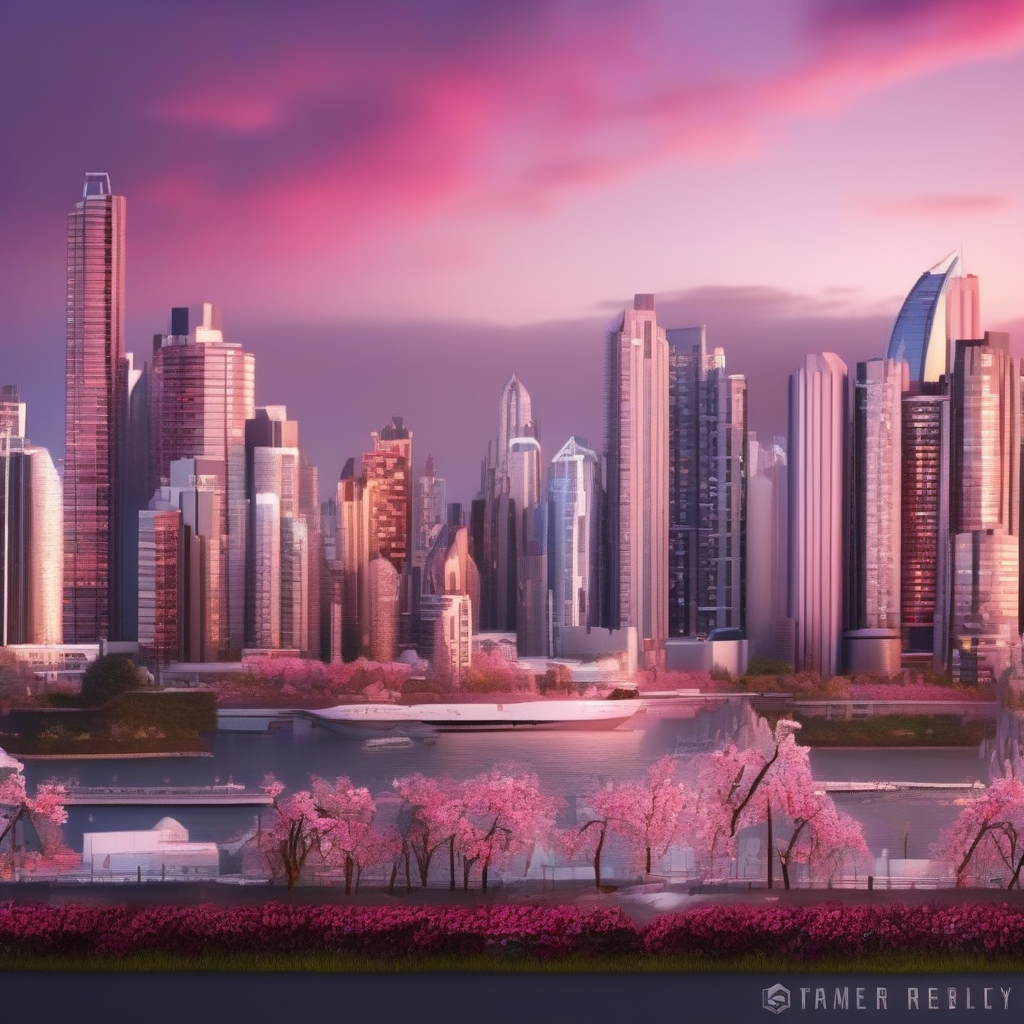